# Исследование надёжности заёмщиков

Первый учебный проект направлен на закрепление навыков предобработки данных.


Заказчик — кредитный отдел банка.  
Необходимо разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.  
Входные данные от банка — статистика о платёжеспособности клиентов.  
  
Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Первый взгляд на данные

In [1]:
#Импортирую необходимые библиотеки
import pandas as pd

from pymystem3 import Mystem
m = Mystem() 

from collections import Counter

#Открываю таблицу и сохраняю ее в переменной data
data = pd.read_csv('/datasets/data.csv')

#Ознакамливаюсь с первыми 10 строками таблицы
display(data.head(10))

#Ознакамливаюсь со свойствами датафрейма
data.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

После получения общей информации о данных стало ясно, что в них есть несколько проблем, с которыми необходимо разобраться при предобработке, а именно:
- в столбце **days_employed** указан общий трудовой стаж в днях, но в нем есть отрицательные значения, это противоречит логике.
- в столбце **days_employed** есть неправдоподобные значения, например в 5 строке есть значение 340266 дней, это больше 900 лет.
- в столбцах **days_employed** и **total_income** есть одинаковое количество пропусков.
- в первых 10 строках уже видно неявные дубликаты в столбцах **education** и **purpose**.
- тип данных указан некорректно для столбца **days_employed**, количество дней является целым числом, поэтому лучше использовать тип **int** вместо **float**.
- тип данных указан некорректно для столбца **total_income**, точности значений, которую предоставляет тип **int** - достаточно.

## Предобработка данных

### Обработка пропусков

Количество пропусков в столбцах **days_employed** и **total_income** - одинаковое.

Предполагаю, что пропуски в этих столбцах допущены в одних и тех же строках.
Проверю это.

In [2]:
#Создадим отдельный датафрейм, в который попадут строки с одновременно пропущенными значениями в обоих столбцах
empty_data = data[data['days_employed'].isna() & data['total_income'].isna()]

#Количество срок в датафрейме с пропусками
display(empty_data.shape[0]) 

#Найдем количество пропусков в каждом из столбцов датафрейма data
display(data.isna().sum())

2174

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Длинна нового датафрейма со строками, где пропущены значения в обоих столбцах (**total_income**, **days_employed**) равна количеству пропусков в каждом из столбцов.
Значит пропуски в данных столбцах допущены в одних и тех же строках.

Мы столкнулись с пропусками неслучайного типа. Вероятно это системная ошибка, появившаяся при сборе или обработке данных банком. В настоящем исследовании необходимо было бы сообщить об этом банку и, возможно, получить датасет заново после исправления ошибки, без пропусков. В таком случае исследование было бы точнее.

Значения в столбце **days_employed** в данном исследовании нам не важны, заменим пропуски в данном столбце нулями.

In [3]:
#Заменим пропуски столбца 'days_employed' на 0
data['days_employed'] = data['days_employed'].fillna(0)

Пропуски в столбце **total_income**, в котором указан ежемесячный доход клиентов банка, для нас важен, так как в ходе исследования мы будем выявлять зависимость между уровнем дохода и возвратом кредита в срок.

Заменю пропуски в столбце **total_income** на медианное значение ежемесечного дохода.

In [4]:
#Заполняю пропуски значением медианного ежемесячного дохода
data['total_income'] = data['total_income'].fillna(data['total_income'].median())

#Проверяю остались ли пропуски в датафрейме
display(data.isna().sum())

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**

В данных были найдены пропуски в столбцах **total_income** и **days_employed**:

- Пропуски в столбце **total_income** заменены медианным значением.
- Пропуски в стобце **days_employed** заменены нулями, так как значения из столбца не участвуют в дальнейшем исследовании.

### Замена типа данных

Заменим тип данных с вещественного на целочисленный.
Воспользуемся методом **.astype('int')**, так как метод **to_numeric()** нам не подходит, он переводит значения в вещественный тип.


In [5]:
#Заменим тип данных для столбца total_income
data['total_income'] = data['total_income'].astype('int')

In [6]:
#Заменим тип данных для столбца days_employed
data['days_employed'] = data['days_employed'].astype('int')
#Проверим корректно ли изменен тип данных в столбцах
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


Также в этом столбце замечены ошибки:

 - общий трудовой стаж указан в днях, но в нем есть отрицательные значения, это противоречит логике.
 - присутствуют неправдоподобные значения, например в 5 строке есть значение 340266 дней, это больше 900 лет.

Проанализируем их.

In [7]:
#Заменим отрицательные значения их модулем.
data['days_employed'] = data['days_employed'].abs()

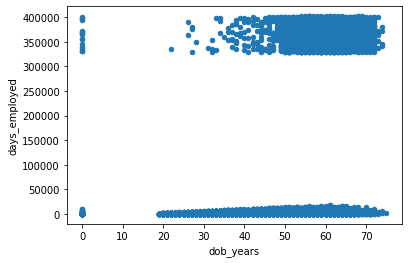

In [8]:
#Построим диаграмму рассеяния трудового стажа и возраста клиентов, чтобы проанализировать значения.
data.plot(x = 'dob_years', y = 'days_employed', kind = 'scatter')

Отрицательные значения трудового стажа успешно обработаны.


Распределение в правом нижнем углу - нормальное. Значения появляются с возраста, в котором становится доступен такой инструмент, как кредит, трудовой стаж растет вместе с возрастом клиента.


Все верхние значения - аномальные, трудовой стаж в этих точках сильно превышает продолжительность жизни человека, здесь явно присутствует ошибка в сборе, обработке или передаче данных.


Существуют значения трудового стажа для людей, возраст которых равен 0, явная ошибка значений возраста для этих значений.

**Вывод**

Тип данных столбца **days_employed** корректно изменен на **int** c помощью метода **.astype()**.

Найдены ошибки в данных, в столбцах **dob_years** и **days_employed**, которые не помешают исследованию, но будут интересны для изучения заказчику.

### Обработка ошибок в данных

Для ответа на поставленные вопросы, нам понадобится использовать данные из столбца **children**, проверим его.

In [9]:
#Посмотрим уникальные значения в столбце и их частоту в датасете
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Видим две явные ошибки: 
- количество детей не может быть отрицательным
- количество семей с 20-ью не может быть больше количества семей с 4 или 5 детьми

Значения -1 и 20 скорее всего обусловлены опечатками при заполнении анкет клиентами/работниками банка.

In [10]:
#Заменим отрицателньые значения их модулем
data['children'] = data['children'].abs()

#Заменим число 20 на число 2
data['children'] = data['children'].replace(20, 2)

#Cнова проверим уникальные значения
data['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

**Вывод**

Выявленные ошибки исправлены.

Необходимо сообщить заказчику об их присутствии в датасете, эта информация может быть полезна, она может повлечь за собой улучшение методики сбора данных.

### Обработка дубликатов

#### Обработка явных дубликатов

In [11]:
#Посчиатем количество явных дубликатов
data.duplicated().sum()

54

In [12]:
#Выведем несколько строк с явными дубликатами, чтобы их проанализировать
duplicated_data = data[data.duplicated()]
duplicated_data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,0,41,среднее,1,женат / замужем,0,F,сотрудник,0,145017,покупка жилья для семьи
4182,1,0,34,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,145017,свадьба
4851,0,0,60,среднее,1,гражданский брак,1,F,пенсионер,0,145017,свадьба
5557,0,0,58,среднее,1,гражданский брак,1,F,пенсионер,0,145017,сыграть свадьбу
7808,0,0,57,среднее,1,гражданский брак,1,F,пенсионер,0,145017,на проведение свадьбы
8583,0,0,58,высшее,0,Не женат / не замужем,4,F,пенсионер,0,145017,дополнительное образование
9238,2,0,34,среднее,1,женат / замужем,0,F,сотрудник,0,145017,покупка жилья для сдачи
9528,0,0,66,среднее,1,вдовец / вдова,2,F,пенсионер,0,145017,операции со своей недвижимостью
9627,0,0,56,среднее,1,женат / замужем,0,F,пенсионер,0,145017,операции со своей недвижимостью
10462,0,0,62,среднее,1,женат / замужем,0,F,пенсионер,0,145017,покупка коммерческой недвижимости


In [13]:
#Посчитаем процентное отношение количества дубликатов к длинне датасета
duplicate_percentage = duplicated_data.shape[0] / data.shape[0] * 100
display(duplicate_percentage)

0.2508710801393728

Дубликатов всего 54 строки. Это очень малое количество (0,25%) относительно количества строк во всем датасете, ими можно принебречь.  
Удалим их, и переназначим индексы строк с помощью методов **.drop_duplicates()** и **.reset_index(drop=True)**

In [14]:
#Удаляю явные дубликаты с обновление индексов строк
data = data.drop_duplicates().reset_index(drop=True)

In [15]:
#Проверяю не осталось ли дубликатов
data.duplicated().sum()

0

#### Обработка неявных дубликатов

Обработаем неявные дубликаты в столбце **education**:

In [16]:
#Найдем неявные дубликаты
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Различия в значениях только в регистре, поэтому воспользуемся методом **.lower()**

In [17]:
#Приводим все значения в столбце education к нижнему регистру
data['education'] = data['education'].str.lower()
#Проверим остались ли неявные дубликаты
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

**Вывод**

Можно улучшить систему сбора данных при сборе информации об уровне образования клиента для избежания появления неявных дубликатов в данных.

Например, можно сделать выпадающий список в анкете, которую заполняет клиент или работник банка, что исключит разные версии написания информации об уровне образования.

### Лемматизация

In [18]:
#Найдем неявные дубликаты в столбце purpose
all_purposes = data['purpose'].unique()
all_purposes

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Из полученного списка можно выделить 4 группы целей получения кредита:
- Приобретение недвижимости
- Приобретение автомобиля
- Получение образования
- Проведение свадьбы

In [19]:
#Переведем список в строку с помощью цикла
all_purposes_str = ''

for purpose in all_purposes:
    all_purposes_str += purpose +' '
    
all_purposes_str

'покупка жилья приобретение автомобиля дополнительное образование сыграть свадьбу операции с жильем образование на проведение свадьбы покупка жилья для семьи покупка недвижимости покупка коммерческой недвижимости покупка жилой недвижимости строительство собственной недвижимости недвижимость строительство недвижимости на покупку подержанного автомобиля на покупку своего автомобиля операции с коммерческой недвижимостью строительство жилой недвижимости жилье операции со своей недвижимостью автомобили заняться образованием сделка с подержанным автомобилем получение образования автомобиль свадьба получение дополнительного образования покупка своего жилья операции с недвижимостью получение высшего образования свой автомобиль сделка с автомобилем профильное образование высшее образование покупка жилья для сдачи на покупку автомобиля ремонт жилью заняться высшим образованием '

In [20]:
#Лемматизируем полученную строку
lemmas = m.lemmatize(all_purposes_str)
Counter(lemmas)

Counter({'покупка': 10,
         ' ': 96,
         'жилье': 7,
         'приобретение': 1,
         'автомобиль': 9,
         'дополнительный': 2,
         'образование': 9,
         'сыграть': 1,
         'свадьба': 3,
         'операция': 4,
         'с': 5,
         'на': 4,
         'проведение': 1,
         'для': 2,
         'семья': 1,
         'недвижимость': 10,
         'коммерческий': 2,
         'жилой': 2,
         'строительство': 3,
         'собственный': 1,
         'подержать': 2,
         'свой': 4,
         'со': 1,
         'заниматься': 2,
         'сделка': 2,
         'получение': 3,
         'высокий': 3,
         'профильный': 1,
         'сдача': 1,
         'ремонт': 1,
         ' \n': 1})

Благодаря счетчику лемм, определяю определяющие леммы для каждой категории цели:
- Приобретение недвижимости (жилье, недвижимость)
- Приобретение автомобиля (автомобиль)
- Получение образования (образование)
- Проведение свадьбы (свадьба)

**Вывод**

Определили леммы для последующей категоризации целей получения кредита.

### Категоризация данных

#### Категоризация по цели получения кредита

Для ответа на поставленный вопрос "Как разные цели кредита влияют на его возврат в срок?" необходимо категоризировать цели получения кредита, воспользуемся полученными определяющими леммами.

In [21]:
#Функция для категоризации значений с помощью лемм
def categorize_by_purpose(purpose):
    
    lemma = m.lemmatize(purpose)
    
    if 'жилье' in lemma:
        return 'Приобретение недвижимости'
    
    if 'недвижимость' in lemma:
        return 'Приобретение недвижимости'
    
    if 'автомобиль' in lemma:
        return 'Приобретение автомобиля'
    
    if 'образование' in lemma:
        return 'Получение образования'
    
    if 'свадьба' in lemma:
        return 'Проведение свадьбы'

In [22]:
#Создадим новый столбец с результатами работы созданной функции 
data['categorized_purpose'] = data['purpose'].apply(categorize_by_purpose)

#Проверим значения нового столбца
display(data['categorized_purpose'].unique())

array(['Приобретение недвижимости', 'Приобретение автомобиля',
       'Получение образования', 'Проведение свадьбы'], dtype=object)

Каждому значению из столбца **purpose** присвоена своя категория.

#### Категоризация по наличию детей

Приступим к категоризации значений из столбца **children**.

Чтобы ответить на вопрос "Есть ли зависимость между наличием детей и возвратом кредита в срок?" необходимо создать 2 категории:
- Нет детей
- Есть дети

In [23]:
#Функция для категоризации значений столбца children
def categorize_by_children(children):
    if children == 0:
        return 'Нет детей'
    if children > 0:
        return 'Есть дети'

In [24]:
#Создадим новый столбец с результатами работы функции categorize_by_children
data['categorized_children'] = data['children'].apply(categorize_by_children)

#Проверим значения нового столбца
display(data['categorized_children'].unique())

array(['Есть дети', 'Нет детей'], dtype=object)

Каждому значению из столбца **children** присвоена своя категория.

#### Категоризация по уровню дохода

Для ответа на вопрос "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?" необходимо категоризировать значения ежемесячного дохода.

In [25]:
#Найдем минимальное и максимальное значение в столбце
display(data['total_income'].min(), data['total_income'].max())

20667

2265604

Выделил следующие категории:
- Выше бедности (20,000 - 30,000)
- Средний достаток (30,000 - 60,000)
- Состоятельные (60,000 - 90,000)
- Богатые (90,000 - 150,000)
- Сверхбогатые (от 150,000)

In [26]:
#Функция для категоризации значений столбца total_income
def categorize_by_income(income):
    if 20000 < income < 30000:
        return 'Выше бедности'
    if 30000 < income < 60000:
        return 'Средний достаток'
    if 60000 < income < 90000:
        return 'Состоятельные'
    if 90000 < income < 150000:
        return 'Богатые'
    if income > 150000:
        return 'Сверхбогатые'

In [27]:
#Создадим новый столбец с результатами работы функции categorize_by_income
data['categorized_income'] = data['total_income'].apply(categorize_by_income)

#Проверим значения нового столбца
display(data['categorized_income'].value_counts())

Сверхбогатые        9184
Богатые             8939
Состоятельные       2542
Средний достаток     784
Выше бедности         22
Name: categorized_income, dtype: int64

**Вывод**

Для последующего анализа была проведена категоризация по **целям получения кредита**, **наличию детей** и **уровню дохода**.

Были выделены следуюзие категории:

**Цели получения кредита**:
- Приобретение недвижимости
- Приобретение автомобиля
- Получение образования
- Проведение свадьбы

**Наличие детей**:
- Нет детей
- Есть дети

**Уровень дохода**:
- Сверхбогатые
- Богатые
- Состоятельные
- Средний достаток
- Выше бедности



## Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Создадим таблицу, где соберем только необходимые данные для ответа на данный вопрос, а именно: наличие детей и имел ли клиеинт задолженность по возврату кредитов.

In [28]:
debt_children = data.loc[:, ['categorized_children','debt','children']]
debt_children

,categorized_children,debt,children
0,Есть дети,0,1
1,Есть дети,0,1
2,Нет детей,0,0
3,Есть дети,0,3
4,Нет детей,0,0
...,...,...,...
21466,Есть дети,0,1
21467,Нет детей,0,0
21468,Есть дети,1,1
21469,Есть дети,1,3


In [29]:
#Для наглядности создадим сводную таблицу

debt_children_pivot = debt_children.pivot_table(
    index = 'categorized_children',
    columns = 'debt',
    values = 'children',
    aggfunc = 'count'
)
debt_children_pivot

debt,0,1
categorized_children,,
Есть дети,6686,678
Нет детей,13044,1063


In [30]:
#Рассчитаем отношение клиентов, которые встречались с задержками по выплатам к общему количеству клиентов
debt_children_pivot['percentage'] = debt_children_pivot[1]/(debt_children_pivot[1]+debt_children_pivot[0]) * 100

#Изменим вид значений нового столбца на процентный и ограничим число знаков после запятой
debt_children_pivot.style.format({'percentage':'{:.2f}%'})

debt,0,1,percentage
categorized_children,,,
Есть дети,6686,678,9.21%
Нет детей,13044,1063,7.54%


In [31]:
#Вычислим насколько чаще заемщики с детьми сталкиваеются с просрочками.
difference = (debt_children_pivot['percentage'][0]-debt_children_pivot['percentage'][1])/debt_children_pivot['percentage'][1]
f'{difference:.1%}'

'22.2%'

**Вывод**

Из сводной таблицы мы видим, что заемщики с детьми сталкиваются имели задолженность по кредитным обязательствам в **9,21%** случаев, а заемщики без детей в **7.54%**.

Выявлена зависимость: Заемщики с детьми сталкиваются с просрочками по выплатам чаще на **22,2%**, чем заемщики без детей.

**Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Создадим таблицу, где соберем только необходимые данные для ответа на данный вопрос, а именно: семейное положение и имел ли клиеинт задолженность по возврату кредитов.

In [32]:
debt_family = data.loc[:, ['family_status','debt','family_status_id']]
debt_family

,family_status,debt,family_status_id
0,женат / замужем,0,0
1,женат / замужем,0,0
2,женат / замужем,0,0
3,женат / замужем,0,0
4,гражданский брак,0,1
...,...,...,...
21466,гражданский брак,0,1
21467,женат / замужем,0,0
21468,гражданский брак,1,1
21469,женат / замужем,1,0


In [33]:
#Ознакомимся с уникальными значениями столбца family_status
debt_family['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

Данные в столбце не нуждаются в дополнительной категоризации.

In [34]:
#Создадим сводную таблицу по таблице debt_family
debt_family_pivot = debt_family.pivot_table(
    index = 'family_status',
    columns = 'debt',
    values = 'family_status_id',
    aggfunc = 'count'
)
debt_family_pivot

debt,0,1
family_status,,
Не женат / не замужем,2536,274
в разводе,1110,85
вдовец / вдова,896,63
гражданский брак,3775,388
женат / замужем,11413,931


In [35]:
#Рассчитаем отношение клиентов, которые встречались с задержками по выплатам к общему количеству клиентов
debt_family_pivot['percentage'] = debt_family_pivot[1]/(debt_family_pivot[1]+debt_family_pivot[0]) * 100

#Изменим вид значений нового столбца на процентный и ограничим число знаков после запятой
debt_family_pivot.style.format({'percentage':'{:.2f}%'})

debt,0,1,percentage
family_status,,,
Не женат / не замужем,2536,274,9.75%
в разводе,1110,85,7.11%
вдовец / вдова,896,63,6.57%
гражданский брак,3775,388,9.32%
женат / замужем,11413,931,7.54%


**Вывод**

Зависимость между семейным положением и возвратом кредита в срок существует.

Можно выделить 2 статуса семейного положения, имея которые люди чаще встречаются с задолженностями при выплате кредита:
- "Не женат / не замужем" - 9.75%
- "гражданский брак" - 9.32%

И 3 статуса семейного положения, имея которые люди реже встречаются с задолженностями при выплате кредита:

- "вдовец / вдова" - 6.57%
- "в разводе" - 7.11%
- "женат / замужем" - 7.54%



**Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

Создадим таблицу, где соберем только необходимые данные для ответа на данный вопрос, а именно: категорию дохода клиента, ежемесячный доход и имел ли клиеинт задолженность по возврату кредитов.

In [36]:
debt_income = data.loc[:, ['categorized_income','debt','total_income']]
debt_income

,categorized_income,debt,total_income
0,Сверхбогатые,0,253875
1,Богатые,0,112080
2,Богатые,0,145885
3,Сверхбогатые,0,267628
4,Сверхбогатые,0,158616
...,...,...,...
21466,Сверхбогатые,0,224791
21467,Сверхбогатые,0,155999
21468,Состоятельные,1,89672
21469,Сверхбогатые,1,244093


In [37]:
#Создадим сводную таблицу по таблице debt_income
debt_income_pivot = debt_income.pivot_table(
    index = 'categorized_income',
    columns = 'debt',
    values = 'total_income',
    aggfunc = 'count'
)
debt_income_pivot

debt,0,1
categorized_income,,
Богатые,8186,753
Выше бедности,20,2
Сверхбогатые,8458,726
Состоятельные,2329,213
Средний достаток,737,47


In [38]:
#Рассчитаем отношение клиентов, которые встречались с задержками по выплатам к общему количеству клиентов
debt_income_pivot['percentage'] = debt_income_pivot[1]/(debt_income_pivot[1]+debt_income_pivot[0]) * 100

#Изменим вид значений нового столбца на процентный и ограничим число знаков после запятой
debt_income_pivot.style.format({'percentage':'{:.2f}%'})

debt,0,1,percentage
categorized_income,,,
Богатые,8186,753,8.42%
Выше бедности,20,2,9.09%
Сверхбогатые,8458,726,7.91%
Состоятельные,2329,213,8.38%
Средний достаток,737,47,5.99%


**Вывод**

Зависимость между уровнем дохода и возвратом кредита в срок существует.


Ответственнее всего к выплате кредита подходят люди со среднем достатком (30,000 - 60,000), сталкиваясь с задолженностями всего в 5.99% случаев.

Остальные категории задалживали по выплатам по кредитам чаще:
- Сверхбогатые 7.91% (от 150,000)
- Состоятельные 8.38% (60,000 - 90,000)
- Богатые 8.42% (90,000 - 150,000)
- Выше бедности 9.09% (20,000 - 30,000)

**Как разные цели кредита влияют на его возврат в срок?**

In [39]:
debt_purpose = data.loc[:, ['categorized_purpose','debt','purpose']]
debt_purpose

,categorized_purpose,debt,purpose
0,Приобретение недвижимости,0,покупка жилья
1,Приобретение автомобиля,0,приобретение автомобиля
2,Приобретение недвижимости,0,покупка жилья
3,Получение образования,0,дополнительное образование
4,Проведение свадьбы,0,сыграть свадьбу
...,...,...,...
21466,Приобретение недвижимости,0,операции с жильем
21467,Приобретение автомобиля,0,сделка с автомобилем
21468,Приобретение недвижимости,1,недвижимость
21469,Приобретение автомобиля,1,на покупку своего автомобиля


In [40]:
#Создадим сводную таблицу по таблице debt_purpose
debt_purpose_pivot = debt_purpose.pivot_table(
    index = 'categorized_purpose',
    columns = 'debt',
    values = 'purpose',
    aggfunc = 'count'
)
debt_purpose_pivot

debt,0,1
categorized_purpose,,
Получение образования,3644,370
Приобретение автомобиля,3905,403
Приобретение недвижимости,10032,782
Проведение свадьбы,2149,186


In [41]:
#Рассчитаем отношение клиентов, которые встречались с задержками по выплатам к общему количеству клиентов
debt_purpose_pivot['percentage'] = debt_purpose_pivot[1]/(debt_purpose_pivot[1]+debt_purpose_pivot[0]) * 100

#Изменим вид значений нового столбца на процентный и ограничим число знаков после запятой
debt_purpose_pivot.style.format({'percentage':'{:.2f}%'})

debt,0,1,percentage
categorized_purpose,,,
Получение образования,3644,370,9.22%
Приобретение автомобиля,3905,403,9.35%
Приобретение недвижимости,10032,782,7.23%
Проведение свадьбы,2149,186,7.97%


**Вывод**

Разные цели кредита влияют на его возврат в срок.

Цель, при которой заемщики реже всего сталкиваются с задолженностями - **Приобретение недвижимости**, в **7.23%** случаев.  
За ней идет **Проведение свадьбы**, заемщики с данной целью кредита сталкиваются с просрочками по платежем чуть чаще, в **7.97%** случаев. 

Хуже показали себя группы заемщиков с целями **"Получение образования"** и **"Приобретение автомобиля"**, они сталкивались с задолженностями чаще, в **9.22%** и в **9.35%** случаев.

## Общий вывод

В полученных данных были найдены недостатки, они были обработаны и их влияние на результаты данного исследования были сведены к минимуму. 
Для будущих исследований по данным, которые будут собраны таким же образом, как и предоставленный датасет, будет полезно проверить и скорректировать процесс их сбора, а именно:
- общий трудовой стаж указан в днях, но в нем есть отрицательные значения, это противоречит логике;
- в столбце общий трудовой стаж присутствуют невозможно большие значения;
- в столбцах общий трудовой стаж и ежемесячный доход присутствуют взаимосвязанные пропуски значений;
- наличие неявных дубликатов в столбцах уровень образования клиента и цель получения кредита;
- значений в столбце общий трудовой стаж можно собирать в целочисленном типе.

В результате данного исследования были получены ответы на следующие вопросы:

**1. Есть ли зависимость между наличием детей и возвратом кредита в срок?**

Зависимость существует. Заемщики с детьми сталкиваются с просрочками по выплатам чаще на 22,2%, чем заемщики без детей. 


**2. Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Зависимость существует. Заемщики со статусами "Не женат / не замужем" или "гражданский брак" справляются с выплатой кредита в срок хуже, чем заемщики со статусами "вдовец / вдова", "в разводе" или "женат / замужем".


**3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

Зависимость существует. Ответственнее всего к выплате кредита подходят люди со среднем достатком (30,000 - 60,000), сталкиваясь с задолженностями всего в 5.99% случаев.

Остальные категории справляются с данной задачей хуже:
- Сверхбогатые (от 150,000) 7.91% 
- Состоятельные (60,000 - 90,000) 8.38%
- Богатые (90,000 - 150,000) 8.42% 
- Выше бедности (20,000 - 30,000) 9.09% 



**4. Как разные цели кредита влияют на его возврат в срок?**

Разные цели кредита влияют на вероятность просрочки по выплатам. **Реже** всего сталкиваются с задолженностями заемщики с целями  **"Приобретение недвижимости"** и **"Проведение свадьбы"**. **Чаще** проблемы с выплатами возникают у заемщиков с целями: **"Получение образования"** и **"Приобретение автомобиля"**.